In [251]:
import numpy as np
import pandas as pd
import seaborn as sns

import string
import collections
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

import math
import sklearn
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import scipy as sc
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import ward, dendrogram

import gensim
from gensim import corpora
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

from itertools import chain
from sklearn.pipeline import Pipeline
import json

pd.options.display.float_format = '{:,.2f}'.format
%precision %.2f
%matplotlib inline

In [218]:
df = pd.read_csv(r'C:\Users\MCOSKUN\songdata.csv')
# remove new lines from lyrics
df['text'] = df.text.apply(lambda x: x.replace('\n',''))
lyrics = df.drop(['link'], axis=1) 
my_arts=['Aerosmith','Bruce Springsteen','Depeche Mode','Jimi Hendrix','Leonard Cohen',
         'Metallica','Paul Simon','Prince','Queen','U2','Indiana Bible College','Nick Cave','Conway Twitty','Grateful Dead','HIM',
         'Leann Rimes','Matt Redman','Nightwish','Peter Cetera','Reba Mcentire','Tool','Whitesnake','Waylon Jennings','Helloween'
]

In [219]:
arts_list = lyrics['artist'].unique()

text_lenght = [0]*24                                 # creating the subtable
my_lyrics = lyrics[lyrics.artist =='Aerosmith']
text_lenght[0] = len(my_lyrics)

for i in range(1,24):
    text_lenght[i]= len(lyrics[lyrics['artist']==my_arts[i]]['text'])
    my_lyrics = my_lyrics.append(lyrics[lyrics.artist ==my_arts[i]])
    i+=1

print(text_lenght)                               # Number of songs per chosen artist  
print(len(my_lyrics))                            # Combined number of songs

[171, 175, 167, 127, 116, 155, 156, 106, 163, 133, 93, 172, 162, 165, 98, 158, 93, 81, 75, 187, 36, 103, 152, 162]
3206


,artist,song,text
145,Aerosmith,All Your Love,All your love I miss lovin' All your kiss I m...
146,Aerosmith,Bacon Biscuit Blues,"Put your biscuits in the oven Honey, put your..."
147,Aerosmith,Blind Man,I took a course in hallelujah I went to night...
148,Aerosmith,Draw The Line,"Checkmate honey, beat ya at your own damn game..."
149,Aerosmith,Eat The Rich,Well I woke up this morning On the wrong side...


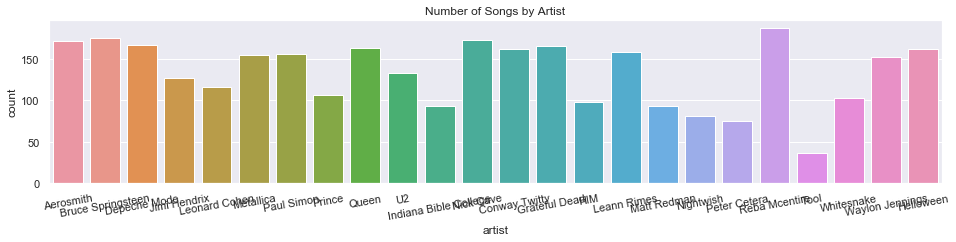

In [220]:
sns.set_context("notebook", font_scale=1.0)
sns.set_palette('cubehelix',4)         
plt.figure(figsize=(16,3))
plt.title('Number of Songs by Artist')
g = sns.countplot(my_lyrics['artist'])
rotg = g.set_xticklabels(g.get_xticklabels(), rotation=10)                                        
my_lyrics.head()

In [221]:
warray = [['']]*24                    # Picking lists of most favorite words by artist
fav_words = [['']]*24
word_cnt = [0]*24
tfidf = TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=True, stop_words='english')
i=0                                                    
for artist, songs in my_lyrics.groupby('artist'):
    my_texts = lyrics[lyrics['artist']==my_arts[i]]['text']               
    tfidf.fit_transform(my_texts)
    cnt = np.sum(tfidf.transform(songs['text']).toarray(), axis=0)
    warray[i] = tfidf.get_feature_names()
    word_cnt[i] = len(warray[i])
    sort_freq = np.argsort(cnt.flatten())[::-1]   
    fav_words[i] = [tfidf.get_feature_names()[idx] for idx in sort_freq.tolist()[:10]]
    print(my_arts[i], "has the most favorite words :",fav_words[i],
         'and the number of unique words in all songs is:', word_cnt[i])
    i+=1 

Aerosmith has the most favorite words : ['yeah', 'love', 'got', 'don', 'baby', 'ain', 'just', 'oh', 'know', 'gotta'] and the number of unique words in all songs is: 3188
Bruce Springsteen has the most favorite words : ['just', 'baby', 'got', 'want', 'love', 'll', 'come', 'like', 'don', 'man'] and the number of unique words in all songs is: 3834
Depeche Mode has the most favorite words : ['love', 'baby', 'don', 'just', 'll', 'know', 'heart', 'oh', 'cause', 've'] and the number of unique words in all songs is: 2374
Jimi Hendrix has the most favorite words : ['ve', 'll', 'love', 'feel', 'want', 'time', 'like', 'know', 'don', 'just'] and the number of unique words in all songs is: 2191
Leonard Cohen has the most favorite words : ['don', 'gonna', 'know', 'got', 'just', 'good', 'way', 'home', 'come', 'ain'] and the number of unique words in all songs is: 2928
Metallica has the most favorite words : ['love', 'heart', 'baby', 'let', 'arms', 've', 'like', 'waiting', 'oh', 'don'] and the number 

In [222]:
comb_texts = ['']*24            # concatenated texts of all songs by the artist
comb_length = [0]*24
i=0
j=0
mn=0
while (i!=len(my_lyrics)):
    comb_texts[j] += (my_lyrics.iloc[i]['text'])
    if (i == text_lenght[j]+ mn ):
        mn+=text_lenght[j]
        j+=1
    i+=1 
for l in range (0,24):
    comb_length[l] = len(comb_texts[l])    
print(comb_length)                         # lenghts of combined strings per artist 

[201787, 224189, 131003, 131294, 141043, 199004, 159100, 159283, 193741, 146717, 82199, 201921, 136064, 168920, 94078, 163985, 82963, 75740, 70747, 177220, 39257, 128777, 124070, 172224]


In [223]:
artists_stats = pd.DataFrame()
artists_stats['artist'] = my_arts
artists_stats['songs'] = text_lenght
artists_stats['words'] = word_cnt
artists_stats['all_length'] = comb_length
artists_stats.head()

,artist,songs,words,all_length
0,Aerosmith,171,3188,201787
1,Bruce Springsteen,175,3834,224189
2,Depeche Mode,167,2374,131003
3,Jimi Hendrix,127,2191,131294
4,Leonard Cohen,116,2928,141043


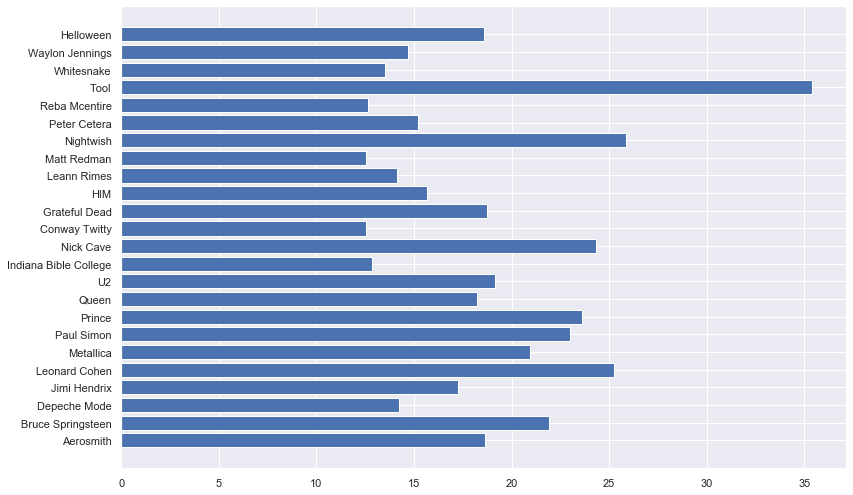

In [243]:
artists_stats['word per song'] = artists_stats.words / artists_stats.songs
y_pos = np.arange(len(artists_stats))
 
# Create horizontal bars
plt.barh(y_pos, artists_stats['word per song'])
 
# Create names on the y-axis
plt.yticks(y_pos, artists_stats['artist'])
 
# Show graphic
plt.show()


In [224]:
topics = ['life','death','love','hate','dream','hell','light','dark','heart','kill','baby','good','super','smile','beautiful','honey','broken','nightmare','bad','cry','fade','black','fall','ugly']

topic_cnt = np.zeros((24,24), int)
i = 0                                    # setting short vocabulary positive/negative pairs
j = 0     

for text in comb_texts:
    for topic in topics:
        topic_cnt[i][j] = text.count(topic)
        j+=1
    j=0    
    i+=1
    
def score_count(a,b,c,d,e,f,g,h,k,l,m,n,o,p,r,s,t,u,v,y,z,a1,b1,c1):
    return (100*(a+b+c+d+e+f+g+h+k+l+m+n)/(o+p+r+s+t+u+v+y+z+a1+b1+c1))            # for better visualization to integer 

In [225]:
topics_energy = ['let','go','hey','oh','eh','yeah','yes','summer','start','energy','big','amazing','cant','no','dying','past','stop','goodbye','winter', 'lose','lonely','tired','done','forgotten']

topic_cnt_energy = np.zeros((24,24), int)
i = 0                                    # setting short vocabulary positive/negative pairs
j = 0     

for text in comb_texts:
    for topic in topics_energy:
        topic_cnt_energy[i][j] = text.count(topic)
        j+=1
    j=0    
    i+=1
    
def score_count_energy(a,b,c,d,e,f,g,h,k,l,m,n,o,p,r,s,t,u,v,y,z,a1,b1,c1):
    return (100*(a+b+c+d+e+f+g+h+k+l+m+n)/(o+p+r+s+t+u+v+y+z+a1+b1+c1))             # for better visualization to integer 

In [226]:
freq_df = pd.DataFrame(topic_cnt)
freq_df.rename(columns= lambda x: topics[x], inplace=True)

freq_df['artist'] = my_arts
col_to_keep=['artist'] + topics 
freq_df = freq_df[col_to_keep]
freq_df['mood_sentiment'] =score_count(freq_df.life,freq_df.love,freq_df.dream,freq_df.light,
                             freq_df.heart,freq_df.baby,freq_df.good,freq_df.super,
                             freq_df.smile,freq_df.beautiful,freq_df.honey,freq_df.death,freq_df.hate,freq_df.hell,
                             freq_df.dark,freq_df.kill,freq_df.broken,freq_df.nightmare,freq_df.bad,freq_df.cry,freq_df.black,freq_df.fall,freq_df.ugly,freq_df.fade)
freq_df.head()                   # table of word frequencies by artist

,artist,life,death,love,hate,dream,hell,light,dark,heart,...,honey,broken,nightmare,bad,cry,fade,black,fall,ugly,mood_sentiment
0,Aerosmith,34,1,319,16,52,23,78,12,47,...,74,12,3,54,32,4,9,80,0,341.338583
1,Bruce Springsteen,48,11,216,10,133,4,119,66,139,...,19,16,0,27,20,9,39,49,0,398.431373
2,Depeche Mode,29,6,165,11,20,3,43,12,61,...,0,15,1,1,15,4,14,29,1,360.000000
3,Jimi Hendrix,21,7,181,2,33,20,23,2,33,...,6,2,0,30,30,1,6,32,0,423.943662
4,Leonard Cohen,35,12,255,10,14,6,73,32,73,...,3,30,0,0,17,0,7,32,0,372.602740


In [227]:
freq_df_energy = pd.DataFrame(topic_cnt_energy)
freq_df_energy.rename(columns= lambda x: topics_energy[x], inplace=True)
freq_df_energy['artist'] = my_arts
col_to_keep_energy=['artist'] + topics_energy
freq_df_energy = freq_df_energy[col_to_keep_energy]
freq_df_energy['mood_energy'] =score_count_energy(freq_df_energy.let,freq_df_energy.go,freq_df_energy.hey,freq_df_energy.oh,
                             freq_df_energy.eh,freq_df_energy.yeah,freq_df_energy.yes,freq_df_energy.summer,
                             freq_df_energy.start,freq_df_energy.energy,freq_df_energy.big,freq_df_energy.amazing,freq_df_energy.energy,
                             freq_df_energy.no, freq_df_energy.dying,freq_df_energy.past,freq_df_energy.stop,freq_df_energy.goodbye,
                             freq_df_energy.winter,freq_df_energy.lose,freq_df_energy.lonely,freq_df_energy.tired,freq_df_energy.done,freq_df_energy.forgotten)
freq_df_energy.head()                      # table of word frequencies by artist

,artist,let,go,hey,oh,eh,yeah,yes,summer,start,...,past,stop,goodbye,winter,lose,lonely,tired,done,forgotten,mood_energy
0,Aerosmith,91,849,136,110,31,248,74,6,25,...,14,48,14,1,31,4,4,30,2,178.764045
1,Bruce Springsteen,95,696,212,89,22,24,81,16,25,...,13,14,10,3,77,28,8,18,1,166.149871
2,Depeche Mode,28,183,92,25,20,7,49,1,21,...,8,19,7,0,30,7,3,16,0,77.436823
3,Jimi Hendrix,56,507,156,58,12,199,34,9,16,...,3,25,1,1,11,14,9,7,1,234.368071
4,Leonard Cohen,70,272,154,30,23,5,21,8,10,...,12,14,11,3,23,10,12,31,2,86.861314


In [228]:
fred_df_2 = freq_df.set_index('artist').merge(freq_df_energy.set_index('artist'), left_on='artist', right_on='artist', how='outer')

In [253]:
fred_df_2['mood'] = fred_df_2['mood_sentiment'] - fred_df_2['mood_energy']/2


In [254]:
fred_df_scaled = fred_df_2.values #returns a numpy array
min_max_scaler = MinMaxScaler()
fred_df_scaled = min_max_scaler.fit_transform(fred_df_scaled)
fred_df_scaled = pd.DataFrame(fred_df_scaled, columns = fred_df_2.columns, index = fred_df_2.index)
fred_df_scaled.head()

,life,death,love,hate,dream,hell,light,dark,heart,kill,...,stop,goodbye,winter,lose,lonely,tired,done,forgotten,mood_energy,mood
artist,,,,,,,,,,,,,,,,,,,,,
Aerosmith,0.23,0.02,0.71,0.38,0.39,0.31,0.61,0.16,0.14,0.14,...,0.75,0.58,0.08,0.38,0.10,0.31,0.52,0.40,0.67,0.28
Bruce Springsteen,0.37,0.18,0.45,0.23,1.00,0.04,1.00,1.00,0.53,0.23,...,0.22,0.42,0.23,1.00,0.70,0.62,0.29,0.20,0.60,0.39
Depeche Mode,0.18,0.10,0.33,0.26,0.15,0.03,0.28,0.16,0.19,0.06,...,0.30,0.29,0.00,0.36,0.18,0.23,0.25,0.00,0.09,0.40
Jimi Hendrix,0.10,0.12,0.37,0.03,0.25,0.27,0.09,0.00,0.08,0.26,...,0.39,0.04,0.08,0.11,0.35,0.69,0.08,0.20,1.00,0.37
Leonard Cohen,0.24,0.20,0.55,0.23,0.11,0.07,0.57,0.47,0.25,0.18,...,0.22,0.46,0.23,0.27,0.25,0.92,0.54,0.40,0.14,0.41


In [255]:
fred_df_scaled['mood_sentiment'].sort_values(ascending = True).head(3)

artist
Metallica   0.00
Helloween   0.00
Tool        0.17
Name: mood_sentiment, dtype: float64

In [262]:
fred_df_scaled['mood_sentiment'].sort_values(ascending = False).head(5)

artist
Reba Mcentire   1.00
Queen           0.88
Whitesnake      0.70
Matt Redman     0.58
Conway Twitty   0.58
Name: mood_sentiment, dtype: float64

In [257]:
fred_df_scaled['mood_energy'].sort_values(ascending = True).head(3)

artist
Tool           0.00
Nightwish      0.05
Depeche Mode   0.09
Name: mood_energy, dtype: float64

In [258]:
fred_df_scaled['mood_energy'].sort_values(ascending = False).head(3)

artist
Queen          1.00
Jimi Hendrix   1.00
Aerosmith      0.67
Name: mood_energy, dtype: float64

In [259]:
fred_df_scaled['mood_energy'].corr(fred_df_scaled['mood_sentiment'])

0.27151301209928935

In [263]:
fred_df_scaled['mood'].sort_values(ascending = False).head(3)

artist
Reba Mcentire   1.00
Queen           0.78
Whitesnake      0.70
Name: mood, dtype: float64

In [264]:
fred_df_scaled['mood'].sort_values(ascending = True).head(3)

artist
Metallica       0.00
Helloween       0.03
Grateful Dead   0.22
Name: mood, dtype: float64

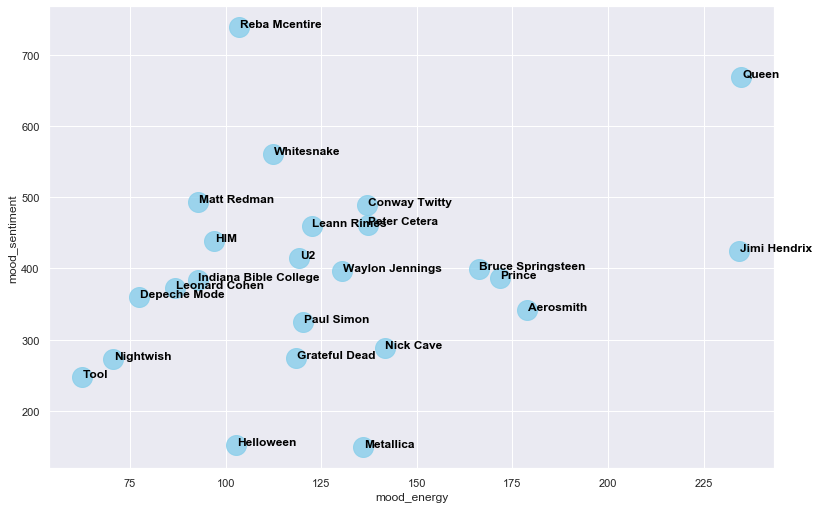

In [238]:
from matplotlib import pyplot
import seaborn as sns

sns.set(rc={'figure.figsize':(13,8.5)})
p1=sns.regplot(data=fred_df_2.reset_index(), x="mood_energy", y="mood_sentiment", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})

# add annotations one by one with a loop
for line in range(0,fred_df_2.reset_index().shape[0]):
     p1.text(fred_df_2.reset_index().mood_energy[line]+0.2, fred_df_2.reset_index().mood_sentiment[line], fred_df_2.reset_index().artist[line], horizontalalignment='left', size='medium', color='black', weight='semibold')